In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

def entropy(labels):
    """
    Compute the entropy of a label distribution.
    """
    if len(labels) == 0:
        return 0.0
    counts = np.bincount(labels)
    probs = counts[counts > 0] / len(labels)
    return -np.sum(probs * np.log2(probs))


def info_gain(parent_labels, left_labels, right_labels):
    """
    Compute standard information gain from splitting parent into left and right.
    """
    h_parent = entropy(parent_labels)
    n = len(parent_labels)
    h_left = entropy(left_labels)
    h_right = entropy(right_labels)
    return h_parent - (len(left_labels) / n) * h_left - (len(right_labels) / n) * h_right


class FairnessDistance:
    """
    Metric that sums normalized Euclidean distance on numeric features and Hamming distance on categorical (one-hot) features.
    """
    def __init__(self, num_idx, cat_idx):
        self.num_idx = num_idx
        self.cat_idx = cat_idx

    def __call__(self, x1, x2):
        # Euclidean on numeric
        num_dist = euclidean(x1[self.num_idx], x2[self.num_idx])
        # Hamming on categorical
        cat_dist = np.sum(x1[self.cat_idx] != x2[self.cat_idx])
        return num_dist + cat_dist


# Fair Decision Tree

class FairTreeNode:
    """
    Node of the fairness-aware decision tree.
    """
    def __init__(self, depth=0):
        self.depth = depth
        self.is_leaf = False
        self.proba = None           # Leaf: class probability vector
        self.split_feature = None   # Internal: feature index to split
        self.split_threshold = None # Internal: threshold for splitting
        self.left = None            # Left child node
        self.right = None           # Right child node

class FairDecisionTreeCustom:
    def __init__(self, K=1.0, lambda_fair=0.5, max_depth=5, min_samples_leaf=10):
        self.K = K
        self.lambda_fair = lambda_fair
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        self.distance_func = None
        self.num_idx = None
        self.cat_idx = None

    def fit(self, X, y, num_features, cat_features):
        
        self.distance_func = FairnessDistance(num_features, cat_features)
        self.num_idx = num_features
        self.cat_idx = cat_features
        indices = np.arange(len(y))
        self.root = self._build_tree(indices, X, y, depth=0)

    def _build_tree(self, idx, X, y, depth):
        node = FairTreeNode(depth)
        if (depth >= self.max_depth) or (len(idx) < 2 * self.min_samples_leaf) or len(np.unique(y[idx])) == 1:
            node.is_leaf = True
            counts = np.bincount(y[idx], minlength=2)
            node.proba = counts / counts.sum()
            return node
        best_score = -np.inf
        best_feat, best_thresh = None, None
        best_left_idx, best_right_idx = None, None
        for feat in range(X.shape[1]):
            thresholds = np.unique(X[idx, feat])
            for thresh in thresholds:
                left_mask = X[idx, feat] <= thresh
                right_mask = ~left_mask
                left_idx = idx[left_mask]
                right_idx = idx[right_mask]
                if len(left_idx) < self.min_samples_leaf or len(right_idx) < self.min_samples_leaf:
                    continue
                gain = info_gain(y[idx], y[left_idx], y[right_idx])
                violation = self._compute_violation(X, y, left_idx, right_idx)
                score = gain - self.lambda_fair * violation
                if score > best_score:
                    best_score = score
                    best_feat = feat
                    best_thresh = thresh
                    best_left_idx = left_idx
                    best_right_idx = right_idx
        if best_feat is None:
            node.is_leaf = True
            counts = np.bincount(y[idx], minlength=2)
            node.proba = counts / counts.sum()
            return node
        node.split_feature = best_feat
        node.split_threshold = best_thresh
        node.left = self._build_tree(best_left_idx, X, y, depth+1)
        node.right = self._build_tree(best_right_idx, X, y, depth+1)
        return node

    def _compute_violation(self, X, y, left_idx, right_idx):
        """
        Compute max violation = max_{i in left, j in right} [TV_dist - K * input_dist]
        where TV_dist = 0.5 |p_i - p_j| using leaf probabilities.
        """
        # get leaf distributions
        # For simplicity, assume binary classification
        # compute probabilities at left and right leaves
        p_left = np.bincount(y[left_idx], minlength=2) / len(left_idx)
        p_right = np.bincount(y[right_idx], minlength=2) / len(right_idx)
        # TV distance between leaf distributions
        tv_leaf = 0.5 * np.sum(np.abs(p_left - p_right))
        # for input distance, sample a few points
        #  we compute average input distance over random sample
        n_samples = min(20, len(left_idx), len(right_idx))
        left_sample = np.random.choice(left_idx, n_samples, replace=False)
        right_sample = np.random.choice(right_idx, n_samples, replace=False)
        d_inputs = []
        for i in left_sample:
            for j in right_sample:
                d_inputs.append(self.distance_func(X[i], X[j]))
        avg_input = np.mean(d_inputs)
        violation = max(0.0, tv_leaf - self.K * avg_input)
        return violation

    def predict_proba(self, X):
        """
        Predict class probabilities for samples.
        """
        probs = np.array([self._predict_one_proba(x, self.root) for x in X])
        return probs

    def _predict_one_proba(self, x, node):
        if node.is_leaf:
            return node.proba
        if x[node.split_feature] <= node.split_threshold:
            return self._predict_one_proba(x, node.left)
        else:
            return self._predict_one_proba(x, node.right)

    def predict(self, X):
        """
        Predict class labels for samples.
        """
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

df = pd.read_csv("compas.csv", parse_dates=[
    "compas_screening_date","dob","c_jail_in","c_jail_out"
])
df = df[
    (df["days_b_screening_arrest"] <= 30) &
    (df["is_recid"] != -1) &
    (df["score_text"] != "N/A")
].copy()

features = ["age","priors_count","c_charge_degree","race","sex"]
target   = "two_year_recid"
X_raw    = df[features]
y        = df[target].values

num_cols = ["age","priors_count"]
scaler   = StandardScaler()
X_num    = scaler.fit_transform(X_raw[num_cols])

cat_cols = ["c_charge_degree","race","sex"]
enc      = OneHotEncoder(drop="first", sparse_output=False)
X_cat    = enc.fit_transform(X_raw[cat_cols])

X = np.hstack([X_num, X_cat])

idx = np.arange(len(df))
train_idx, test_idx, y_train, y_test = train_test_split(
    idx, y, test_size=0.2, stratify=y, random_state=42
)
X_train = X[train_idx]
X_test  = X[test_idx]

df_test = df.iloc[test_idx].reset_index(drop=True)


num_idx = list(range(X_num.shape[1]))
cat_idx = list(range(X_num.shape[1], X.shape[1]))

fdt = FairDecisionTreeCustom(
    K=0.5, lambda_fair=0.7,
    max_depth=5, min_samples_leaf=20
)
fdt.fit(X_train, y_train, num_features=num_idx, cat_features=cat_idx)

y_pred = fdt.predict(X_test)


In [ ]:
def compute_dataset_violation(tree, X, K):
    """
    For a fitted FairDecisionTreeCustom 'tree', compute:
      - max_violation = max_{i<j, different leaves} [TV(i,j) - K*d(i,j)]
      - avg_violation over a random sample of pairs.
    """
    # 1) assign each sample to its leaf and record its leaf-proba
    leaf_ids = []
    leaf_probas = []
    def traverse(x, node, leaf_id=0):
        if node.is_leaf:
            return id(node), node.proba
        if x[node.split_feature] <= node.split_threshold:
            return traverse(x, node.left)
        else:
            return traverse(x, node.right)
    for x in X:
        lid, proba = traverse(x, tree.root)
        leaf_ids.append(lid)
        leaf_probas.append(proba)
    leaf_ids = np.array(leaf_ids)
    leaf_probas = np.vstack(leaf_probas)  # shape (n,2)

    # 2) build an index by leaf
    from collections import defaultdict
    leaf_to_idx = defaultdict(list)
    for i, lid in enumerate(leaf_ids):
        leaf_to_idx[lid].append(i)

    # 3) sample pairs from different leaves
    violations = []
    leaves = list(leaf_to_idx.keys())
    for _ in range(5000):  # adjust sample size
        # pick two leaves
        l1, l2 = np.random.choice(leaves, size=2, replace=False)
        i = np.random.choice(leaf_to_idx[l1])
        j = np.random.choice(leaf_to_idx[l2])
        # TV distance of outputs:
        tv = 0.5 * np.sum(np.abs(leaf_probas[i] - leaf_probas[j]))
        # input distance:
        din = tree.distance_func(X[i], X[j])
        violations.append(max(0.0, tv - K * din))

    return max(violations), np.mean(violations)


In [4]:
def compute_group_metrics(df_test, y_pred, y_true, group_col):
    """
    df_test: original DataFrame for your X_test (aligned rowwise)
    y_pred: predictions array
    y_true: true labels array
    group_col: string column name, e.g. 'race'
    """
    groups = df_test[group_col].unique()
    metrics = {}

    for g in groups:
        idx = df_test[group_col] == g
        preds = y_pred[idx]
        trues = y_true[idx]

        # Demographic parity: P(pred=1)
        dp = preds.mean()

        # True-positive rate
        if trues.sum() > 0:
            tpr = np.sum((preds==1)&(trues==1)) / np.sum(trues==1)
        else:
            tpr = np.nan

        # False-positive rate
        n_neg = np.sum(trues==0)
        if n_neg > 0:
            fpr = np.sum((preds==1)&(trues==0)) / n_neg
        else:
            fpr = np.nan

        metrics[g] = {"DP":dp, "TPR":tpr, "FPR":fpr}

    # compute gaps
    dp_vals  = [m["DP"]  for m in metrics.values() if not np.isnan(m["DP"])]
    tpr_vals = [m["TPR"] for m in metrics.values() if not np.isnan(m["TPR"])]
    fpr_vals = [m["FPR"] for m in metrics.values() if not np.isnan(m["FPR"])]

    gaps = {
        "DP_gap": max(dp_vals)-min(dp_vals),
        "EO_gap": max(tpr_vals)-min(tpr_vals),
        "PE_gap": max(fpr_vals)-min(fpr_vals)
    }

    return metrics, gaps


In [ ]:
# 1. Lipschitz‐fairness violations
max_v, avg_v = compute_dataset_violation(fdt, X_test, K=0.5)
print(f"Max fairness violation: {max_v:.4f}")
print(f"Avg fairness violation: {avg_v:.4f}")

# 2. Group‐fairness by race
group_stats, group_gaps = compute_group_metrics(df_test, y_pred, y_test, group_col="race")
print("\nPer‐group metrics:")
for g, m in group_stats.items():
    print(f"  {g}: DP={m['DP']:.3f}, TPR={m['TPR']:.3f}, FPR={m['FPR']:.3f}")
print("\nGaps:")
for name, gap in group_gaps.items():
    print(f"  {name}: {gap:.3f}")


Max fairness violation: 0.5469
Avg fairness violation: 0.0010

Per‐group metrics:
  Caucasian: DP=0.283, TPR=0.426, FPR=0.183
  African-American: DP=0.492, TPR=0.669, FPR=0.312
  Hispanic: DP=0.168, TPR=0.250, FPR=0.116
  Other: DP=0.221, TPR=0.276, FPR=0.188
  Asian: DP=0.125, TPR=0.000, FPR=0.143
  Native American: DP=0.000, TPR=nan, FPR=0.000

Gaps:
  DP_gap: 0.492
  EO_gap: 0.669
  PE_gap: 0.312


Accuracy Pivot Table:
K               0.100     0.575     1.050     1.525     2.000
lambda_fair                                                  
0.100        0.665660  0.664151  0.664151  0.664151  0.664151
0.325        0.662642  0.664151  0.664151  0.664151  0.664151
0.550        0.664906  0.664151  0.664151  0.664151  0.664151
0.775        0.664906  0.664151  0.664151  0.664151  0.664151
1.000        0.664906  0.664151  0.664151  0.664151  0.664151

Max Violation Pivot Table:
K               0.100     0.575    1.050     1.525     2.000
lambda_fair                                                 
0.100        0.569471  0.245071  0.00000  0.000000  0.000000
0.325        0.458780  0.245071  0.24974  0.000000  0.000000
0.550        0.465434  0.288893  0.24974  0.247658  0.000000
0.775        0.416086  0.152251  0.00000  0.000000  0.000000
1.000        0.425006  0.192704  0.24974  0.339743  0.169467


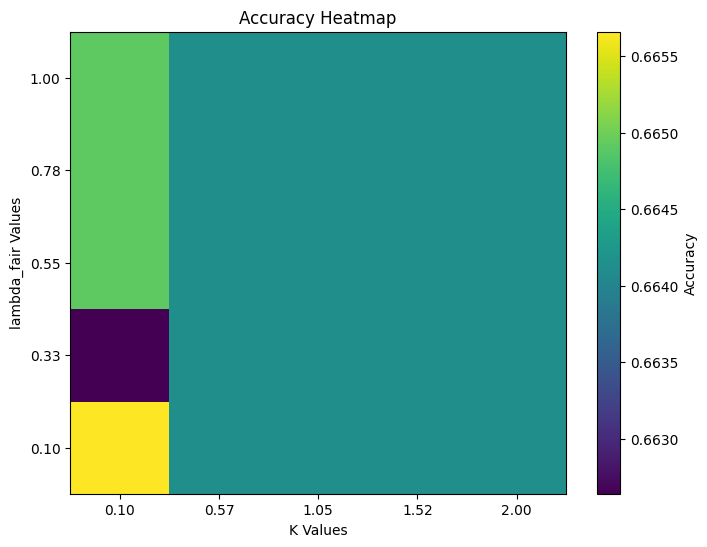

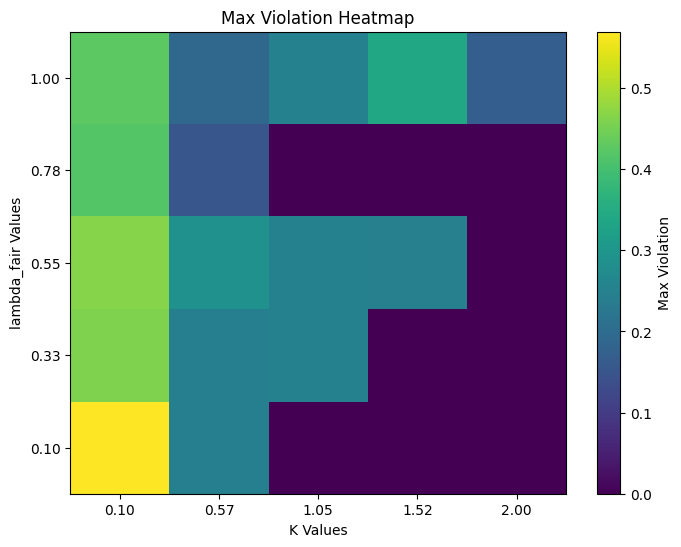

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

K_values      = np.linspace(0.1, 2.0, 5)   # Lipschitz constants to iterate through
lambda_values = np.linspace(0.1, 1.0, 5)   # Fairness‐penalty weights to try

results = []

for K in K_values:
    for lam in lambda_values:
        model = FairDecisionTreeCustom(
            K=K,
            lambda_fair=lam,
            max_depth=5,
            min_samples_leaf=20
        )
        model.fit(X_train, y_train, num_features=num_idx, cat_features=cat_idx)
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        max_v = compute_dataset_violation(model, X_test, K)
        
        results.append({
            'K': K,
            'lambda_fair': lam,
            'accuracy': acc,
            'max_violation': max_v
        })
df_results = pd.DataFrame(results)

pivot_acc   = df_results.pivot(index='lambda_fair', columns='K', values='accuracy')
pivot_vio   = df_results.pivot(index='lambda_fair', columns='K', values='max_violation')

print("Accuracy Pivot Table:")
print(pivot_acc)

print("\nMax Violation Pivot Table:")
print(pivot_vio)

plt.figure(figsize=(8, 6))
plt.title('Accuracy Heatmap')
plt.imshow(pivot_acc, origin='lower', aspect='auto')
plt.colorbar(label='Accuracy')
plt.xlabel('K Values')
plt.ylabel('lambda_fair Values')
plt.xticks(range(len(K_values)), [f"{k:.2f}" for k in K_values])
plt.yticks(range(len(lambda_values)), [f"{l:.2f}" for l in lambda_values])
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Max Violation Heatmap')
plt.imshow(pivot_vio, origin='lower', aspect='auto')
plt.colorbar(label='Max Violation')
plt.xlabel('K Values')
plt.ylabel('lambda_fair Values')
plt.xticks(range(len(K_values)), [f"{k:.2f}" for k in K_values])
plt.yticks(range(len(lambda_values)), [f"{l:.2f}" for l in lambda_values])
plt.show()

